## 13.13.实战 Kaggle 比赛：图像分类 (CIFAR-10)

In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import mindspore
from mindspore import nn
from d2l import mindspore as d2l

#### 13.13.1.1. 下载数据集

In [2]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

#### 13.13.1.2. 整理数据集

In [3]:
#@save
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 1000
# 类别 : 10


In [4]:
#@save
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

In [5]:
#@save
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

In [6]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [7]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

### 13.13.2. 图像增广

In [8]:
transform_train = mindspore.dataset.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    mindspore.dataset.vision.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    mindspore.dataset.vision.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    mindspore.dataset.vision.RandomHorizontalFlip(),
    mindspore.dataset.vision.ToTensor(),
    # 标准化图像的每个通道
    mindspore.dataset.vision.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010], is_hwc=False)])

In [9]:
transform_test = mindspore.dataset.transforms.Compose([
    mindspore.dataset.vision.ToTensor(),
    mindspore.dataset.vision.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010], is_hwc=False)])

### 13.13.3. 读取数据集

In [10]:
train_ds, train_valid_ds = [mindspore.dataset.ImageFolderDataset(
    os.path.join(data_dir, 'train_valid_test', folder), shuffle=True, decode=True).map(transform_train, 'image')
                            for folder in ['train', 'train_valid']]

valid_ds, test_ds = [mindspore.dataset.ImageFolderDataset(
    os.path.join(data_dir, 'train_valid_test', folder), shuffle=False, decode=True).map(transform_test, 'image')
                     for folder in ['valid', 'test']]

In [11]:
train_iter, train_valid_iter = [dataset.batch(batch_size=batch_size, drop_remainder=True)
                                for dataset in (train_ds, train_valid_ds)]

valid_iter = valid_ds.batch(batch_size=batch_size, drop_remainder=True)

test_iter = test_ds.batch(batch_size=batch_size, drop_remainder=False)

### 13.13.4. 定义模型

In [12]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

### 13.13.5. 定义训练函数

In [13]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, lr_period, lr_decay):
    
    lr_list = d2l.tensor([lr*lr_decay**(i//lr_period) 
                          for i in range(num_epochs) 
                          for j in range(train_iter.get_dataset_size())])
    trainer = nn.SGD(net.trainable_params(), learning_rate=lr_list, momentum=0.9,
                              weight_decay=wd)

    def forward_fn(inputs, targets):
        logits = net(inputs)
        l = loss(logits, targets)
        return l, logits
    
    grad_fn = mindspore.value_and_grad(forward_fn, None, trainer.parameters, has_aux=True)
    
    def train_step(inputs, targets):
        (l, logits), grads = grad_fn(inputs, targets)
        trainer(grads)
        return l, logits
    
    num_batches, timer = train_iter.get_dataset_size(), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)

    for epoch in range(num_epochs):
        net.set_train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            
            l, acc = d2l.train_batch_ch13(train_step, features, labels)
            
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))

    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec')

### 13.13.6. 训练和验证模型

train loss 0.323, train acc 0.898, valid acc 0.344
385.0 examples/sec


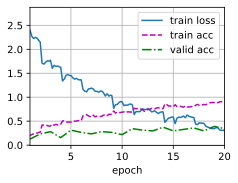

In [14]:
num_epochs, lr, wd = 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, lr_period, lr_decay)

### 13.13.7. 在 Kaggle 上对测试集进行分类并提交结果

train loss 2.218, train acc 0.273
432.6 examples/sec


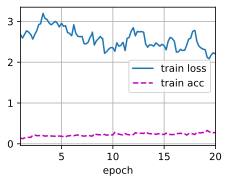

In [15]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, lr_period, lr_decay)

for X, _ in test_iter:
    y_hat = net(X)
    preds.extend(y_hat.argmax(axis=1).numpy().astype('int32'))
sorted_ids = list(range(1, test_ds.get_dataset_size() + 1))
sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': preds})
class_indexing = train_ds.get_class_indexing()
classes = sorted(class_indexing.items(), key=lambda x: x[0])
df['label'] = df['label'].apply(lambda x: classes[x][0])
df.to_csv('submission.csv', index=False)